# Analyse des modèles de reconnaissance de caractères basés sur le dataset NIST

Le but de ce notebook est d'analyser différents modèles créés pour la reconnaissance des caractères manuscrits. Les modèles ont été entrainés sur le dataset [NIST Special Database 19](https://www.nist.gov/srd/nist-special-database-19).

## Importation des dépendances

Les dépendances nécessaires à l'analyse de ces models sont :
- [tensorflow](https://www.tensorflow.org/?hl=fr)
- [matplotlib](https://matplotlib.org/)
- [pandas](https://pandas.pydata.org/)

In [1]:
import os
import multiprocessing as mp
from typing import Literal
from string import ascii_letters

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from src.util import DatasetLoader
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras

## Définition des paramètres

On définit ici les paramètres du notebook :
- l'emplacement des modèles entrainés
- l'emplacement des datasets
- l'emplacement du dataset de test
- la taille des images du dataset
- la taille des chunks utilisés lors du chargement du dataset

In [2]:
MODELS_DIR = "../../models"
NIST_PROCESSED_PATH = "../../data/processed/NIST-dataset"
TEST_SET_PATH = os.path.join(NIST_PROCESSED_PATH, "test", "nist_processed_test.csv")
IMG_SIZE = 41
CHUNK_SIZE = 25000

## Chargement du dataset de test

On crée ici le `DatasetLoader` et on charge le jeu de données.

In [3]:
loader = DatasetLoader(IMG_SIZE)

In [4]:
def get_x_y_from_csv_multi_process(
            path: str,
            chunk_size: int,
            engine: Literal["c", "python", "pyarrow", "python-fwf"] = "c"
    ) -> tuple:
        chunks = pd.read_csv(path,   engine=engine, chunksize=chunk_size)
        cpu_count = mp.cpu_count()

        with mp.Pool(cpu_count) as pool:
            data_list = [data for data in pool.map(loader.get_y_and_x_set_from_dataframe, chunks)]

        data = list(zip(*data_list))
        y_set = np.concatenate(data[0])
        x_set = np.concatenate(data[1])

        return y_set, x_set

In [5]:
y, x = get_x_y_from_csv_multi_process(TEST_SET_PATH, CHUNK_SIZE)

In [6]:
print(x.shape)
print(y.shape)

(123391, 41, 41)
(123391, 1)


## Encodage des labels

Afin de pouvoir tester le modèle, on encode les labels utilisés pour la classification. On commence par construire un encodeur adapté à nos labels.

In [7]:
labels = list(ascii_letters)
encoder = LabelBinarizer()
encoder.fit(labels)

LabelBinarizer()

On encode ensuite les labels de notre dataset.

In [8]:
y_encoded = encoder.transform(y)

## Chargement des modèles entrainés

On charge ici les modèles déjà entrainés par nos soins.

In [9]:
models1_path = []
models2_path = []
for model_dir in os.scandir(MODELS_DIR):
    if "-1-" in model_dir.name:
        models1_path.append(os.path.join(MODELS_DIR, model_dir.name, "model"))
    elif "-2-" in model_dir.name:
        models2_path.append(os.path.join(MODELS_DIR, model_dir.name, "model"))

In [10]:
print(models1_path)
print(models2_path)

['../../models\\20230501-1-204211\\model', '../../models\\20230501-1-204503\\model', '../../models\\20230501-1-204804\\model', '../../models\\20230501-1-205316\\model', '../../models\\20230501-1-210220\\model', '../../models\\20230501-1-214336\\model']
['../../models\\20230501-2-204211\\model', '../../models\\20230501-2-220919\\model', '../../models\\20230501-2-221254\\model', '../../models\\20230501-2-221612\\model', '../../models\\20230501-2-221940\\model', '../../models\\20230502-2-094013\\model']


In [11]:
models1: [keras.Model] = []
for model1_path in models1_path:
    models1.append(keras.models.load_model(model1_path))

models2: [keras.Model] = []
for model2_path in models2_path:
    models2.append(keras.models.load_model(model2_path))

In [12]:
for model in models1 + models2:
    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1681)              0         
                                                                 
 dense (Dense)               (None, 866)               1456612   
                                                                 
 dense_1 (Dense)             (None, 52)                45084     
                                                                 
Total params: 1,501,696
Trainable params: 1,501,696
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1681)              0         
                                                                 
 dense_2 (Dense)        

In [13]:
for model in models1:
    for layer in model.layers:
        print(layer.__class__.__name__)
    break

Flatten
Dense
Dense


In [14]:
model1_data = pd.DataFrame(columns=["dense_count", "err_validation"])
model2_data = pd.DataFrame(columns=["dense_count", "err_validation"])

In [15]:
for model in models1:
    nb_dense = -1
    for layer in model.layers:
        if isinstance(layer, keras.layers.Dense):
            nb_dense += 1
    eval_data = model.evaluate(x, y_encoded, verbose=2)
    model1_data.loc[len(model1_data)] = [nb_dense, eval_data[0]]

for model in models2:
    nb_dense = -1
    for layer in model.layers:
        if isinstance(layer, keras.layers.Dense):
            nb_dense += 1
    eval_data = model.evaluate(x, y_encoded, verbose=2)
    model2_data.loc[len(model2_data)] = [nb_dense, eval_data[0]]

3856/3856 - 10s - loss: 0.7747 - acc: 0.7660 - 10s/epoch - 3ms/step
3856/3856 - 10s - loss: 0.8183 - acc: 0.7447 - 10s/epoch - 3ms/step
3856/3856 - 10s - loss: 0.6345 - acc: 0.7970 - 10s/epoch - 3ms/step
3856/3856 - 11s - loss: 0.5856 - acc: 0.8089 - 11s/epoch - 3ms/step
3856/3856 - 10s - loss: 0.5751 - acc: 0.8102 - 10s/epoch - 3ms/step
3856/3856 - 11s - loss: 0.5972 - acc: 0.8042 - 11s/epoch - 3ms/step
3856/3856 - 10s - loss: 0.7747 - acc: 0.7660 - 10s/epoch - 3ms/step
3856/3856 - 12s - loss: 0.6647 - acc: 0.7912 - 12s/epoch - 3ms/step
3856/3856 - 13s - loss: 0.5862 - acc: 0.8097 - 13s/epoch - 3ms/step
3856/3856 - 14s - loss: 0.5298 - acc: 0.8259 - 14s/epoch - 4ms/step
3856/3856 - 16s - loss: 0.5453 - acc: 0.8139 - 16s/epoch - 4ms/step
3856/3856 - 18s - loss: 0.5383 - acc: 0.8141 - 18s/epoch - 5ms/step


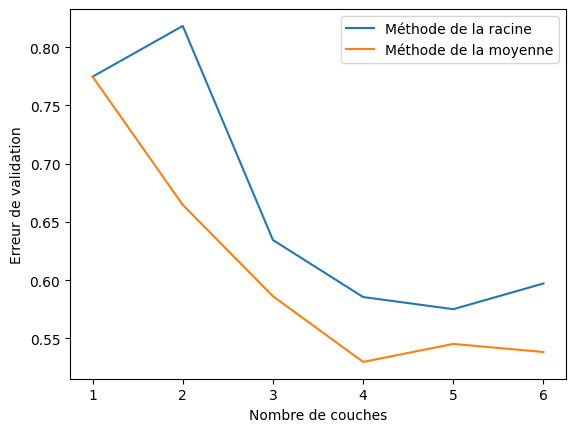

In [16]:
plt.plot(model1_data["dense_count"], model1_data["err_validation"], label="Méthode de la racine")
plt.plot(model2_data["dense_count"], model2_data["err_validation"], label="Méthode de la moyenne")

#plt.title("Courbe de validation de l'erreur")
plt.xticks(range(1, 7))
plt.xlabel("Nombre de couches")
plt.ylabel("Erreur de validation")
plt.legend()

plt.savefig("fig.png")
plt.show()